<a href="https://colab.research.google.com/github/vardanagarwal/crowd_counting/blob/master/csrnet_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip install torchvision

ERROR: torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import zipfile
zf = zipfile.ZipFile('/content/drive/My Drive/ShanghaiTech_Crowd_Counting_Dataset.zip', "r")
zf.extractall()

In [0]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
import torchvision.transforms.functional as F
from matplotlib import cm as CM
from image import *
import torch

In [0]:
import h5py
import torch
import shutil

def save_net(fname, net):
    with h5py.File(fname, 'w') as h5f:
        for k, v in net.state_dict().items():
            h5f.create_dataset(k, data=v.cpu().numpy())
def load_net(fname, net):
    with h5py.File(fname, 'r') as h5f:
        for k, v in net.state_dict().items():        
            param = torch.from_numpy(np.asarray(h5f[k]))         
            v.copy_(param)
            
def save_checkpoint(state, is_best,task_id, filename='checkpoint.pth.tar'):
    torch.save(state, task_id+filename)
    if is_best:
        shutil.copyfile(task_id+filename, task_id+'model_best.pth.tar')

In [0]:
import torch.nn as nn
import torch
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in xrange(len(self.frontend.state_dict().items())):
                self.frontend.state_dict().items()[i][1].data[:] = mod.state_dict().items()[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)     

In [0]:
model = CSRNet()


In [9]:
model = model.cuda()
checkpoint = torch.load('/content/drive/My Drive/0model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [38]:
part_A_train = os.path.join('part_A_final/train_data','images')
part_A_test = os.path.join('part_A_final/test_data','images')
path_sets = [part_A_train]
path_train = [part_A_test]

img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(str(img_path))
TRAIN_LEN = len(img_paths)
print("Total train images : ",TRAIN_LEN)

test_paths = []
for path in path_train:
    for test_path in glob.glob(os.path.join(path, '*.jpg')):
        test_paths.append(str(test_path))
TEST_LEN = len(test_paths)
print("Total test images : ",TEST_LEN)

('Total train images : ', 400)
('Total test images : ', 316)


In [0]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
                  ])

In [41]:
import pandas as pd

mae = 0
values = []
for i in range(len(test_paths)):
    img = transform(Image.open(test_paths[i]).convert('RGB')).cuda()
    output_path = os.path.join('/content/drive/My Drive/ShanghaiTech_h5', test_paths[i].replace('.jpg','.h5').replace('images','ground'))
    gt_file = h5py.File(output_path,'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
    values.append([output.detach().cpu().sum().numpy(), np.sum(groundtruth)])
print (mae/len(img_paths))

20.57942922592163


In [0]:
df = pd.DataFrame(values, columns=['ground truth', 'prediction'])

In [0]:
df.to_csv('csrnet_partA.csv')

('Predicted Count : ', 727)


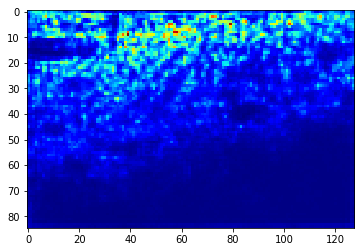

('Original Count : ', 905)


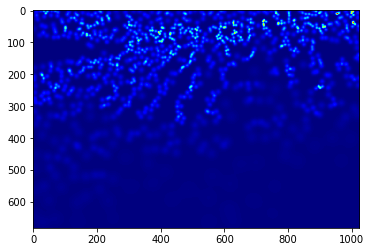

Original Image


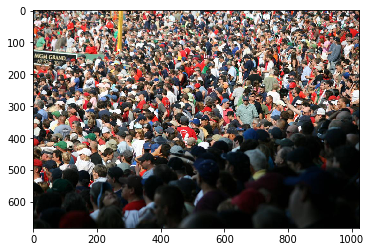

torch.Size([1, 1, 85, 128])
(683, 1024)


In [27]:
from matplotlib import cm as c
img = transform(Image.open('part_A_final/test_data/images/IMG_10.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/My Drive/ShanghaiTech_h5/part_A_final/test_data/ground/IMG_10.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('part_A_final/test_data/images/IMG_10.jpg'))
plt.show()
print(output.shape)
print(temp_1.shape)